#### Стоимость жилья требует значительных инвестиций как со стороны потребителей, так и со стороны застройщиков. И когда дело доходит до планирования бюджета — будь то личного или корпоративного, — последнее, что кому-либо нужно, - это неопределенность в отношении одного из своих самых крупных расходов. Сбербанк, старейший и крупнейший банк России, помогает своим клиентам прогнозировать цены на недвижимость, чтобы арендаторы, застройщики и кредиторы были более уверены при заключении договора аренды или покупке здания.
#### В этом ноутбуке проводится аналитическое исследование большого количества факторов на стоимость жилья. Набор данных включает информацию об общих условиях в экономике и финансовом секторе России. Данные собраны с августа 2011 по июнь 2015 года. 

# Описание данных:
* price_doc: цена продажи
* id: id транзакции
* timestamp: дата транзакции
* full_sq: общая площадь в квадратных метрах, включая лоджии, балконы и другие нежилые помещения
* life_sq: жилая площадь в квадратных метрах, исключая лоджии, балконы и другие нежилые помещения
* floor: для квартир этаж здания
* max_floor: количество этажей в здании
* material: материал
* build_year: год постройки
* num_room: количество жилых комнат
* kitch_sq: площадь кухни
* state: состояние квартиры
* product_type: покупка или инвестиция, осуществляемая владельцем
* sub_area: название района

Набор данных также включает в себя набор характеристик, относящихся к окрестностям каждого объекта недвижимости, и некоторые характеристики, которые являются постоянными в каждой подобласти (известной как район). Большинство названий говорят сами за себя, со следующими примечаниями. Полный список приведен ниже.

* full_all: население района
* male_f, female_f: население района в разбивке по полу
* young_*: население моложе трудоспособного возраста
* work_*: население трудоспособного возраста
* ekder_*: население пенсионного возраста
* n_m_{all|male|female}: население в возрасте от n до m лет
* build_count_*: здания в районе по типу постройки или году
* x_count_500: количество x в радиусе 500 метров от объекта
* x_part_500: доля x в пределах 500 м от объекта недвижимости
* _sqm_: квадратных метров
* cafe_count_d_price_p: количество кафе в радиусе d метров от отеля, в которых проверяется средний счет
* trc_: торговые центры
* prom_: промышленные зоны
* green_: зеленые зоны
* metro_: метро
* _avto_: расстояние до машин
* mkad_: московская кольцевая автомобильная дорога
* ttk_: третье транспортное кольцо
* sadovoe_: садовое кольцо
* bulvar_ring_: бульварное кольцо
* kremlin_: центр города
* zd_vokzaly_: железнодорожный вокзал
* oil_chemistry_: грязная промышленность
* ts_: электростанция

# Этапы выполенения проекта
* Отсутствующие данные
* Проблемы с качеством данных
* Признаки исобенность дома
* Демографические признаки
* Образовательные признаки
* Культурные/рекреационные признаки
* Инфраструктурные признаки
* Исследование важности признаков

# Загрузка библиотек и данных

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from matplotlib.ticker import FixedLocator, FixedFormatter
import datetime
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import catboost as cb
import xgboost as xgb

%matplotlib inline

pd.set_option("display.max_columns", 500)
color = sns.color_palette()
pd.options.mode.chained_assignment = None
plt.rcParams["axes.grid"] = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
z = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/train.csv.zip')
z.extractall()

In [4]:
train_df = pd.read_csv('/kaggle/working/train.csv', parse_dates=['timestamp'])
train_df['price_doc_log'] = np.log1p(train_df['price_doc'])

In [5]:
train_df.shape

(30471, 293)

Посмотрим на случайные 10 строк таблицы

In [6]:
train_df.sample(10)

id  timestamp  full_sq  life_sq  floor  max_floor  material  \
20757  20760 2014-07-10       38      NaN    3.0       17.0       1.0   
18531  18534 2014-05-16       49     34.0    3.0        9.0       1.0   
20324  20327 2014-06-28      167      NaN    1.0        1.0       1.0   
17533  17536 2014-04-17       40     19.0    2.0        7.0       2.0   
10724  10727 2013-09-25       46      1.0   12.0        1.0       1.0   
7127    7130 2013-04-08       45     29.0    2.0        NaN       NaN   
5445    5448 2012-12-24       40      NaN    8.0        NaN       NaN   
10958  10961 2013-10-03       63     60.0    6.0       17.0       1.0   
23263  23266 2014-10-04       49      NaN   17.0       17.0       4.0   
1304    1307 2012-02-24       74     45.0    4.0        NaN       NaN   

       build_year  num_room  kitch_sq  state   product_type  \
20757         NaN       1.0       1.0    1.0  OwnerOccupier   
18531      1969.0       3.0       6.0    2.0     Investment   
20324         NaN       3.0       1.0    NaN  OwnerOccupier   
17533      1957.0       2.0       9.0    2.0     Investment   
10724         NaN       1.0       1.0    1.0  OwnerOccupier   
7127          NaN       NaN       NaN    NaN     Investment   
5445          NaN       NaN       NaN    NaN  OwnerOccupier   
10958      2015.0       2.0      10.0    1.0  OwnerOccupier   
23263         NaN       1.0      10.0    NaN  OwnerOccupier   
1304          NaN       NaN       NaN    NaN     Investment   

                       sub_area        area_m  raion_popul  green_zone_part  \
20757                  Tverskoe  7.307411e+06        75377         0.065444   
18531          Vyhino-Zhulebino  1.509487e+07       219609         0.300284   
20324       Poselenie Rogovskoe  1.762464e+08         2693         0.649578   
17533     Pokrovskoe Streshnevo  1.308980e+07        53786         0.183969   
10724       Poselenie Sosenskoe  6.677245e+07         9553         0.336177   
7127           Losinoostrovskoe  5.361327e+06        80917         0.197068   
5445           Severnoe Tushino  9.249237e+06       156377         0.374068   
10958                Nekrasovka  1.139168e+07        19940         0.055644   
23263   Poselenie Voskresenskoe  2.149409e+07         7122         0.262459   
1304   Orehovo-Borisovo Juzhnoe  7.128794e+06       145576         0.075790   

       indust_part  children_preschool  preschool_quota  \
20757     0.000078                4237           1874.0   
18531     0.033494               10167           7610.0   
20324     0.004949                 189              NaN   
17533     0.150818                3051            922.0   
10724     0.072158                 656              NaN   
7127      0.036122                4169           1926.0   
5445      0.000000               10190           4116.0   
10958     0.243205                1706           2395.0   
23263     0.017647                 489              NaN   
1304      0.100456                5594           4792.0   

       preschool_education_centers_raion  children_school  school_quota  \
20757                                  4             6398        6772.0   
18531                                 10            10573       16049.0   
20324                                  0              186           NaN   
17533                                  2             3433        3577.0   
10724                                  0              629           NaN   
7127                                   3             4378        6839.0   
5445                                   5            11319        9891.0   
10958                                  5             1564        7377.0   
23263                                  0              469           NaN   
1304                                   7             7227       11178.0   

       school_education_centers_raion  school_education_centers_top_20_raion  \
20757                               4                                      1   
18531 

Получим общее представление о данных

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 293 entries, id to price_doc_log
dtypes: datetime64[ns](1), float64(120), int64(157), object(15)
memory usage: 68.1+ MB


# Пропущенные значения

В данных имеются пропущенные значения
Рассмотрим сколько имеются пропущенных значений и распределение пропущенных значений по каждому из признаков

In [8]:
train_na = (train_df.isnull().sum()/train_df.shape[0]) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

In [9]:
print(f"Максимальный процент пропусков в признаке {train_na.idxmax()}: {train_na.max().round(2)}%")
print(f"Минимальный процент пропусков в признаке {train_na.idxmin()}: {train_na.min().round(2)}%")

Максимальный процент пропусков в признаке hospital_beds_raion: 47.39%
Минимальный процент пропусков в признаке ID_railroad_station_walk: 0.08%


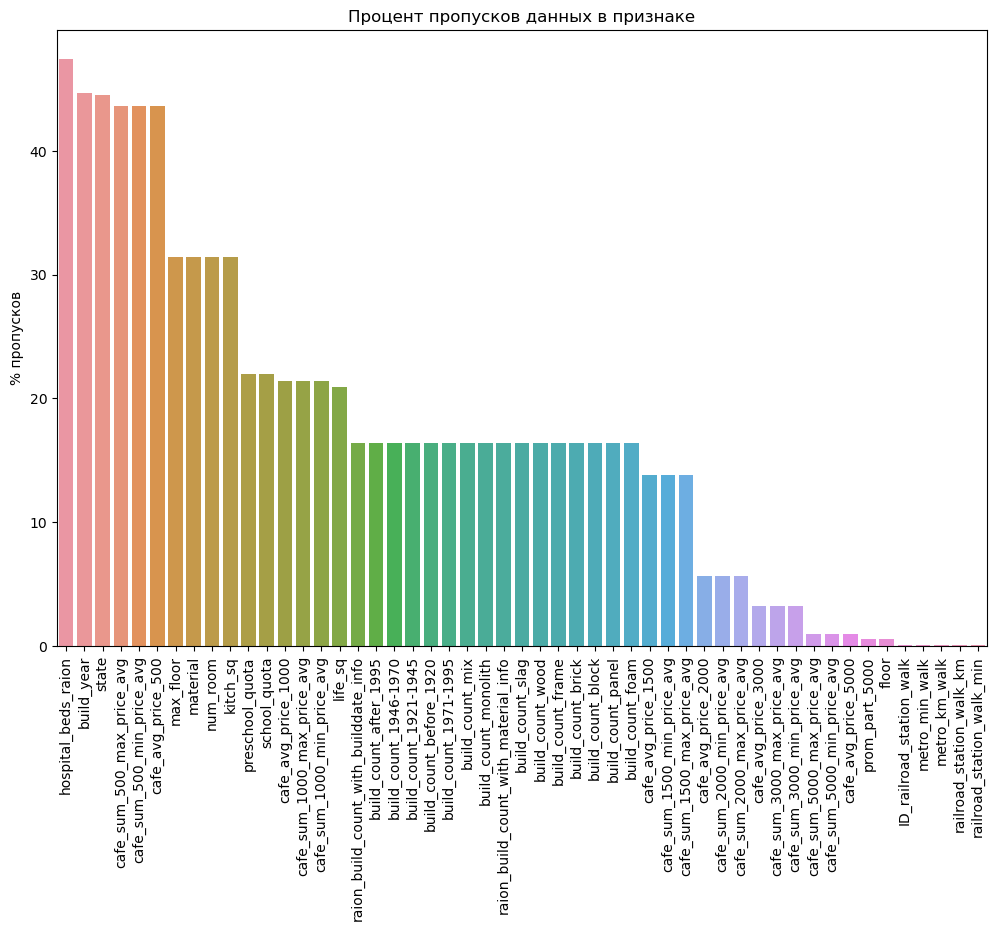

In [10]:
f, ax = plt.subplots(figsize= (12,8))
plt.xticks(rotation="vertical")
sns.barplot(x=train_na.index, y=train_na)
ax.set(title="Процент пропусков данных в признаке", ylabel="% пропусков")
ax.grid(False)

Как можно заметить из данных в 51 из 292 столбцов имеются пропущенные значения. Процент пропущенных значений колеблется от 0,08% в ID_railroad_station_walk до 47,39% в hospital_beds_raion.

# Предобработка данных

Рассмотрим данные на наличие ошибок

Для начала рассмотрим все не категориальные признаки и дату переведем в числовой вид

In [11]:
train_df_non_cat = train_df.select_dtypes(exclude=['object'])
for col in train_df_non_cat.columns:
    if train_df_non_cat[col].dtype == 'datetime64[ns]':
        train_df_non_cat[col] = train_df_non_cat[col].apply(lambda x: x.timestamp())

Построим boxplot для каждого из признаков

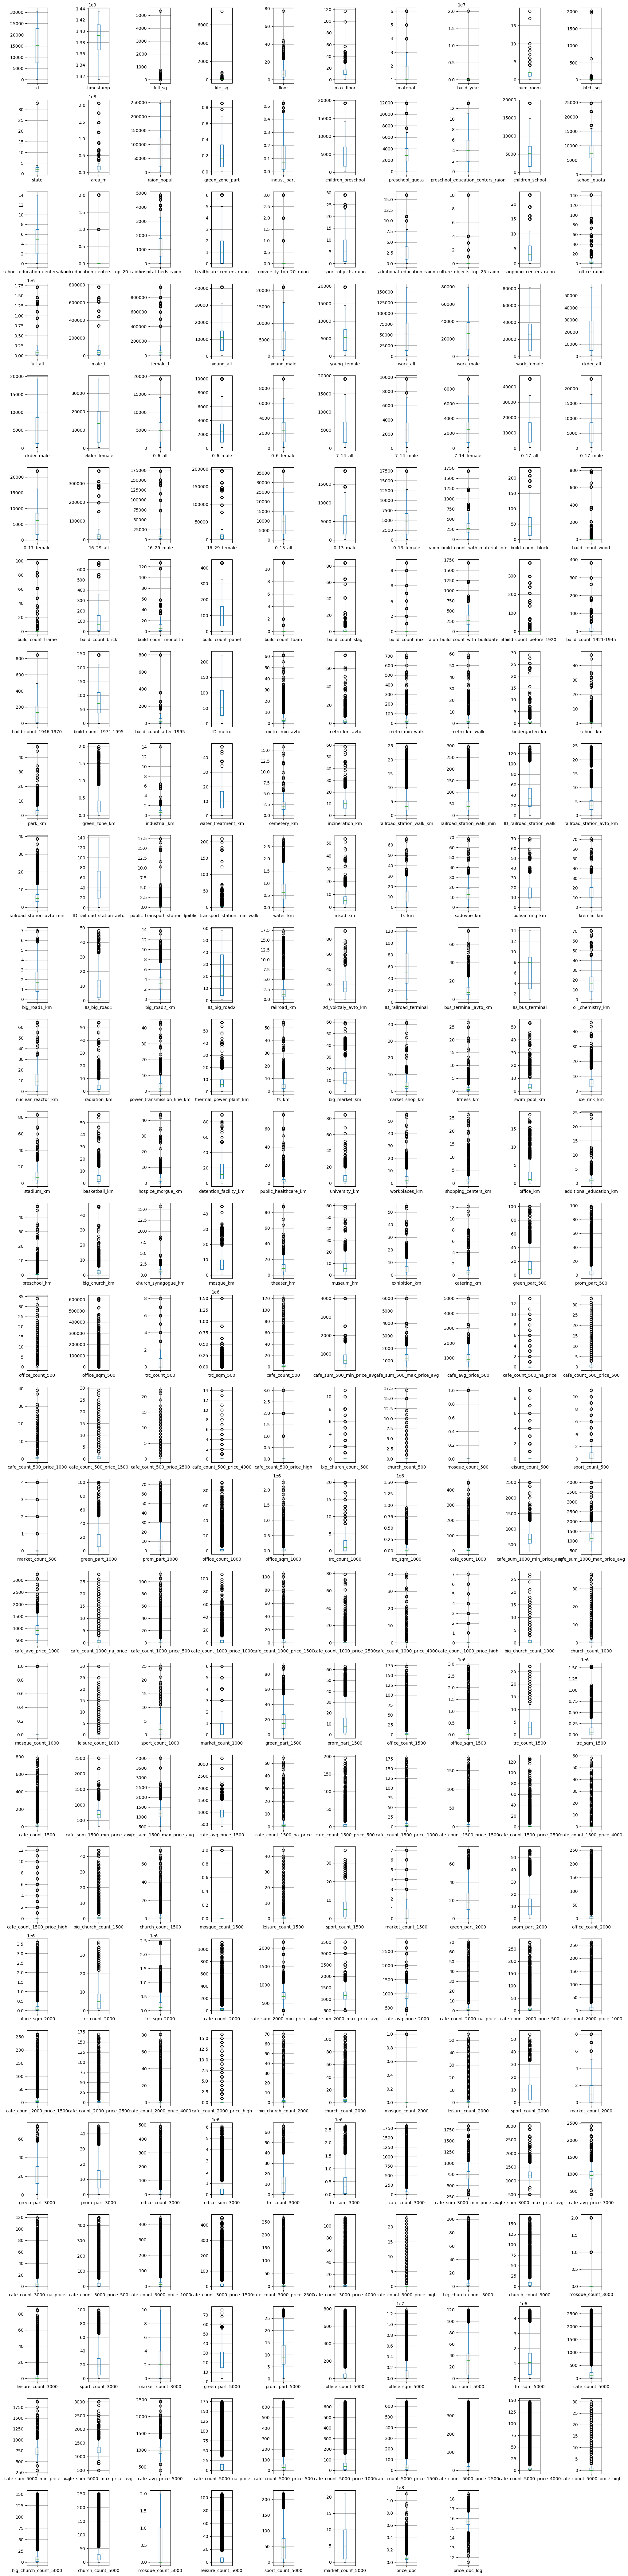

In [12]:
columns = train_df_non_cat.columns

num_rows = (len(columns) + 9) // 10
num_cols = min(len(columns), 10)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3*num_rows))

for i, col in enumerate(columns):
    ax = axes[i // 10, i % 10] if num_rows > 1 else axes[i % 10]
    train_df_non_cat.boxplot(column=col, ax=ax)

if len(columns) % 10 != 0:
    for i in range(len(columns), num_rows * num_cols):
        ax = axes[i // 10, i % 10] if num_rows > 1 else axes[i % 10]
        ax.remove()
plt.tight_layout()
plt.show()

Данный подход не лучшим образом позволяет оценить количество выбросов и неверных данных. Но при этом даже при данном способе видно, что в данных, где state=33 и build_year порядка 20млн неверные и стоит их подкорректировать.

Заменим значение state с 33 на 3. Также год постройки свыше 20млн заменим на подходящее значение.

In [13]:
train_df.loc[train_df['state'] == 33, 'state'] = train_df['state'].mode().iloc[0]

In [14]:
train_df["build_year"].max()

20052009.0

Скорее всего значение года постройки должно находится в промежутке с 2005 по 2009. Возьмем среднее 2007.

In [15]:
train_df.loc[train_df['build_year'] == 20052009, 'build_year'] = 2007

Также заметно, что имеется серьезный выброс в общей площади и жилой площади. В дальнейшем опустим данные значения. 

In [16]:
train_df.size

8928003

In [17]:
train_df = train_df.drop(train_df[train_df['full_sq'] > 2000].index)
train_df.size


8927710

In [18]:
train_df = train_df.drop(train_df[train_df['life_sq'] > 2000].index)
train_df.size

8927417

Параметр full_sq означает "общая площадь в квадратных метрах, включая лоджии, балконы и другие нежилые помещения", а параметр life_sq означает "жилая площадь в квадратных метрах, исключая лоджии, балконы и другие нежилые помещения". Таким образом, должно быть так, что life_sq всегда меньше, чем full_sq. Если данные условия не соблюдается, то также исключим данные.

In [19]:
(train_df['life_sq'] > train_df['full_sq']).sum()

36

In [20]:
train_df = train_df.drop(train_df[train_df["life_sq"] > train_df["full_sq"]].index)

# Анализ данных
## Внутренние характеристики дома
Рассмотрим корелляцию между внутренними характеристиками дома и ценой

In [21]:
internal_features = ["full_sq", "life_sq", "floor", "max_floor", "build_year", "num_room", "kitch_sq", "state", "price_doc"]
corr_matrix = train_df[internal_features].corr()

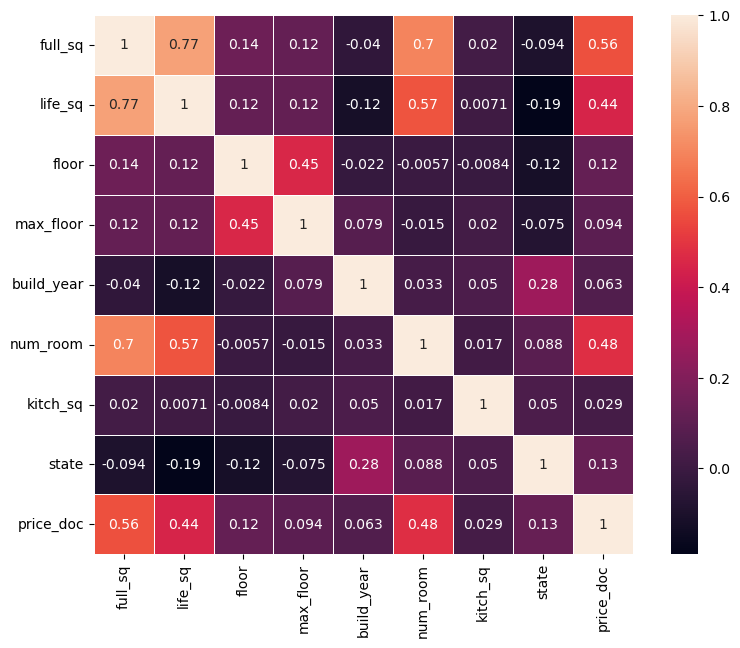

In [22]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation="vertical")
sns.heatmap(corr_matrix, square=True, linewidths=0.5, annot=True)
ax.grid(False)

Как видно из корреляционной матрицы, то количество комнат num_room и общая площадь full_sq наилучшим образом коррелируют с ценой price_doc. Рассмотрим их.

### Общая площадь и количество комнат
#### Общая площадь
Построим диаграмму рассеяния (scatter plot) для общей площади

[Text(0.5, 1.0, 'Цена за квадратный метр'),
 Text(0.5, 0, 'Площадь'),
 Text(0, 0.5, 'Цена')]

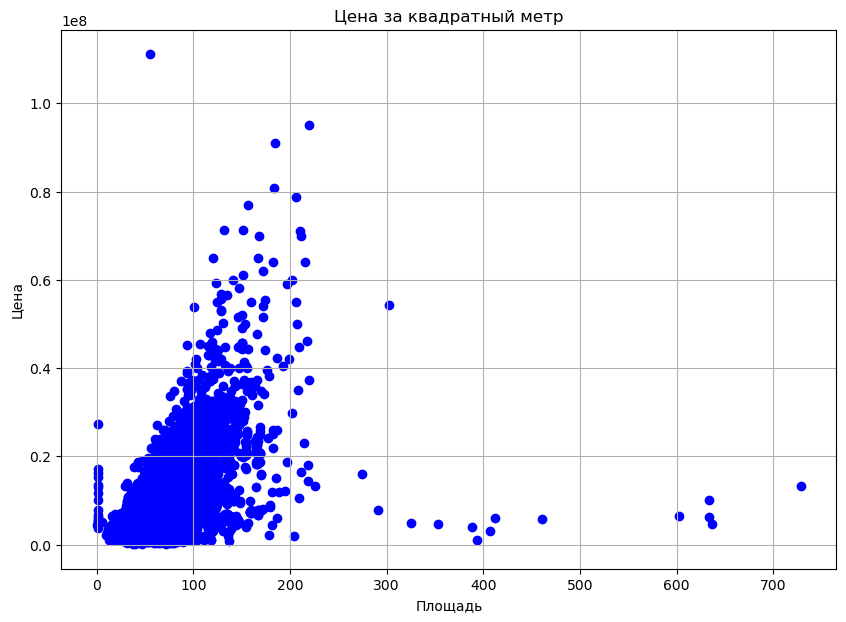

In [23]:
f, ax = plt.subplots(figsize=(10, 7))
plt.scatter(x=train_df["full_sq"], y=train_df["price_doc"], c="b")
ax.set(title="Цена за квадратный метр", xlabel="Площадь", ylabel="Цена")

#### Количество комнат

Посмотрим все уникальные значения, которые может принимать параметр num_rooms, а также их количество

In [24]:
train_df.value_counts("num_room")

num_room
2.0     8122
1.0     7597
3.0     4665
4.0      418
5.0       40
0.0       14
6.0        9
8.0        3
10.0       2
7.0        1
9.0        1
17.0       1
19.0       1
dtype: int64

Построим распределение количества комнат

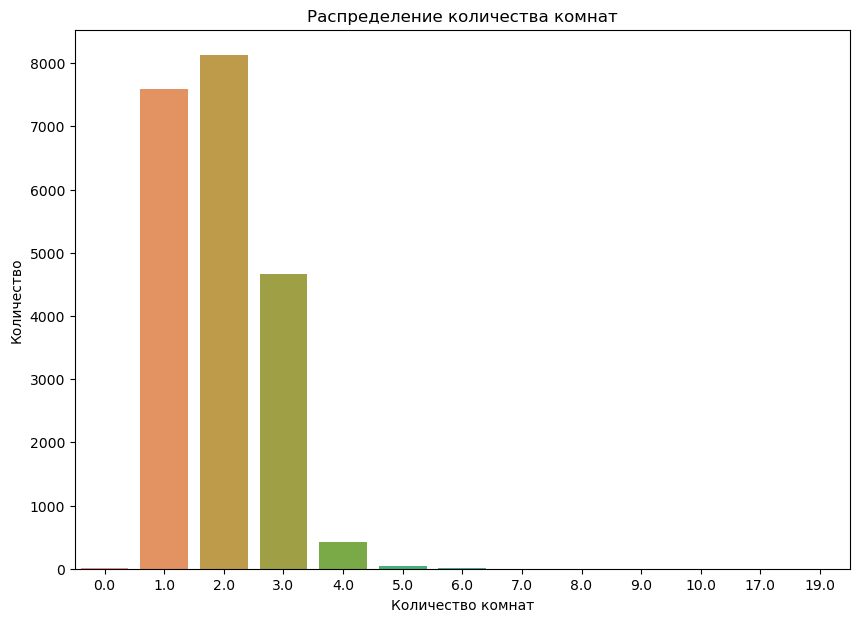

In [25]:
f, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x=train_df["num_room"])
ax.set(title='Распределение количества комнат', xlabel='Количество комнат', ylabel='Количество')
ax.grid(False)

Как видно из данной зависимости, то основная часть проданых квартир приходится 3 и менее комнат

### Тип продажи
Рассмотрим имеется ли разница в цене на дома, купленные владельцем-арендатором, или на дома, купленные для инвестиций.


In [26]:
train_df["product_type"].unique()

array(['Investment', 'OwnerOccupier'], dtype=object)

In [27]:
train_df["price_doc_log"]

0        15.581952
1        15.607270
2        15.555977
3        16.388123
4        16.608603
           ...    
30466    15.816991
30467    17.034386
30468    15.757264
30469    16.418200
30470    15.538277
Name: price_doc_log, Length: 30433, dtype: float64

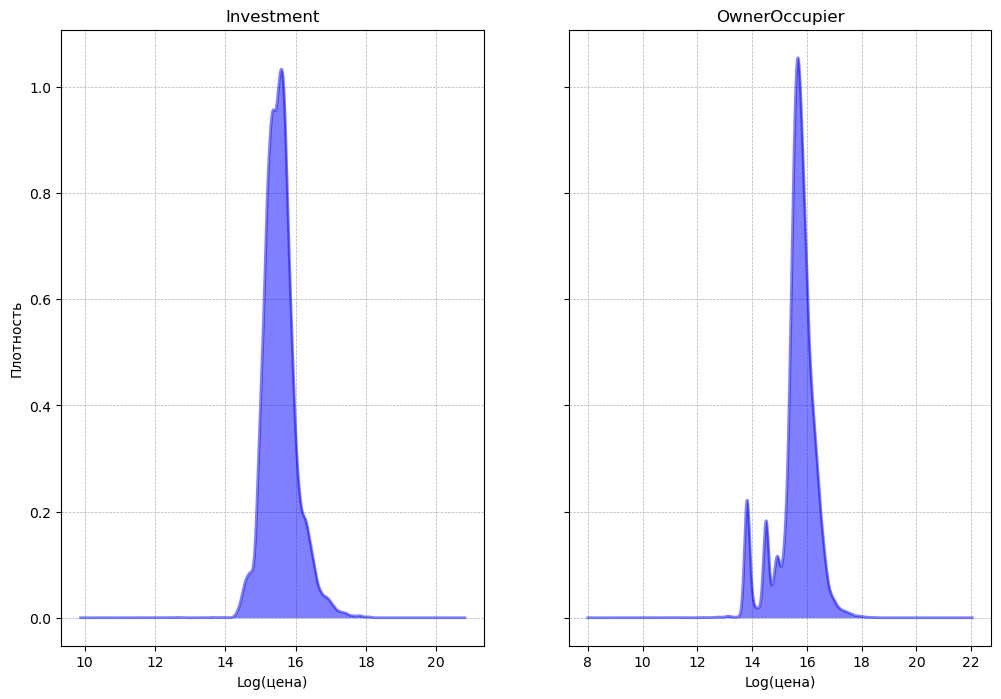

In [28]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
options_plot = {"color": "blue", 'alpha': 0.5, 'lw': 2}
options_grid = {"which":'both', "linestyle":'--', "linewidth":0.5}
options_set = {"xlabel":'Log(цена)', "ylabel":'Плотность'}
titles= ["Investment", "OwnerOccupier"]
investment_kde = train_df.drop(train_df[train_df['product_type'] == 'Investment'].index)["price_doc_log"].plot.kde(ax=ax[0], **options_plot).get_lines()[0]
owner_kde = train_df.drop(train_df[train_df['product_type'] == 'OwnerOccupier'].index)["price_doc_log"].plot.kde(ax=ax[1], **options_plot).get_lines()[0]

for i, plot in enumerate(ax):
    ax[i].set(**options_set, title=titles[i])
    ax[i].grid(**options_grid)
    ax[i].set_axisbelow(True)
    ax[i].fill_between(investment_kde.get_xdata() if i == 0 else owner_kde.get_xdata(), 
                       investment_kde.get_ydata() if i == 0 else owner_kde.get_ydata(),
                       color=options_plot['color'], alpha=options_plot['alpha'], lw=0)

In [29]:
train_df.groupby("product_type")["price_doc"].median()

product_type
Investment       6682970.5
OwnerOccupier    5559427.0
Name: price_doc, dtype: float64

Из графика плотности распределения можно заметить,что дома, проданные для инвестиций, продаются дороже, чем дома, проданные владельцам-арендаторам.

### Год застройки

Посмотрим на уникальные значения годов постройки и их количество

In [30]:
pd.set_option("display.max_rows", None)
train_df.value_counts("build_year").sort_index()

build_year
0.0       528
1.0       368
3.0         2
20.0        1
71.0        1
215.0       1
1691.0      1
1860.0      2
1876.0      1
1886.0      1
1890.0      5
1895.0      1
1896.0      2
1900.0      2
1904.0      1
1905.0      1
1906.0      1
1907.0      2
1910.0      5
1911.0      1
1912.0      5
1914.0      3
1915.0      5
1917.0     16
1920.0      1
1924.0      3
1925.0      1
1926.0      8
1927.0     10
1928.0     12
1929.0     12
1930.0      6
1931.0      6
1932.0      8
1933.0      7
1934.0     13
1935.0     11
1936.0      5
1937.0     10
1938.0      9
1939.0      7
1940.0     14
1941.0      2
1943.0      2
1946.0      2
1947.0      4
1948.0      1
1949.0      3
1950.0     22
1951.0     23
1952.0     45
1953.0     24
1954.0     36
1955.0     52
1956.0     48
1957.0    119
1958.0    179
1959.0    208
1960.0    344
1961.0    297
1962.0    338
1963.0    324
1964.0    315
1965.0    378
1966.0    348
1967.0    384
1968.0    389
1969.0    407
1970.0    417
1971.0    352
1972.0   

В данном наборе данных присутствуют дома построенные в 0м, 1м, 3м, 20м, 71м, 215, 4965м годах. Стоит их исключить в дальнейшем от рассмотрения. Также на момент публикации данных домов 2018года быть не может, так как набор данных до 2017 года.

In [31]:
train_df = train_df.drop(train_df.query("build_year >=2018 or build_year < 1691").index)

In [32]:
pd.set_option("display.max_rows", 60)
train_df.value_counts("build_year").sort_index()

build_year
1691.0      1
1860.0      2
1876.0      1
1886.0      1
1890.0      5
         ... 
2013.0    463
2014.0    912
2015.0    823
2016.0    373
2017.0    154
Length: 110, dtype: int64

Построим распределение количества домом по годам застройки

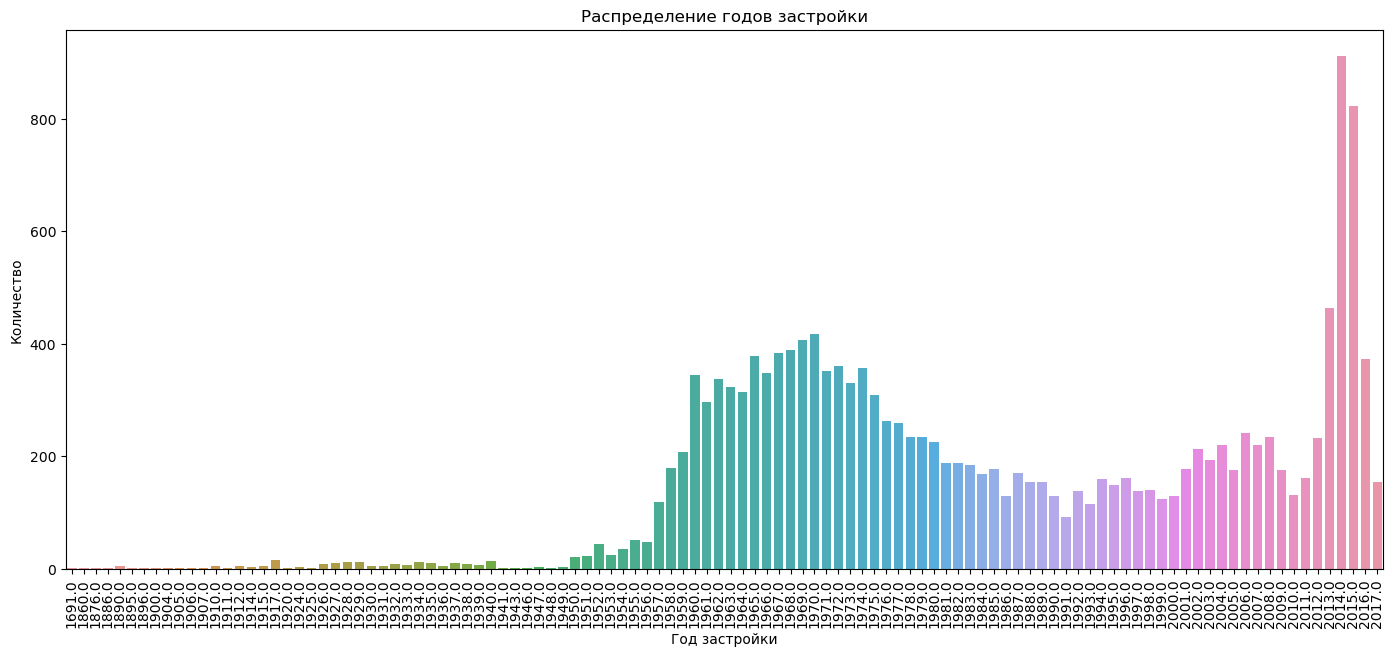

In [33]:
f, ax = plt.subplots(figsize=(17, 7))
plt.xticks(rotation='vertical')
sns.countplot(x=train_df["build_year"])
ax.set(title='Распределение годов застройки', xlabel='Год застройки', ylabel='Количество')
ax.grid(False)

Как можно заметить распределение похоже на бимодальное с пиками в 1970 и 2014 годах

Посмотрим связан ли год постройки с ценой. Рассмотрим распределение средних значений цены от года постройки

[Text(0.5, 1.0, 'Распределение средней цены от года постройки'),
 Text(0.5, 0, 'Год постройки'),
 Text(0, 0.5, 'Средняя цена')]

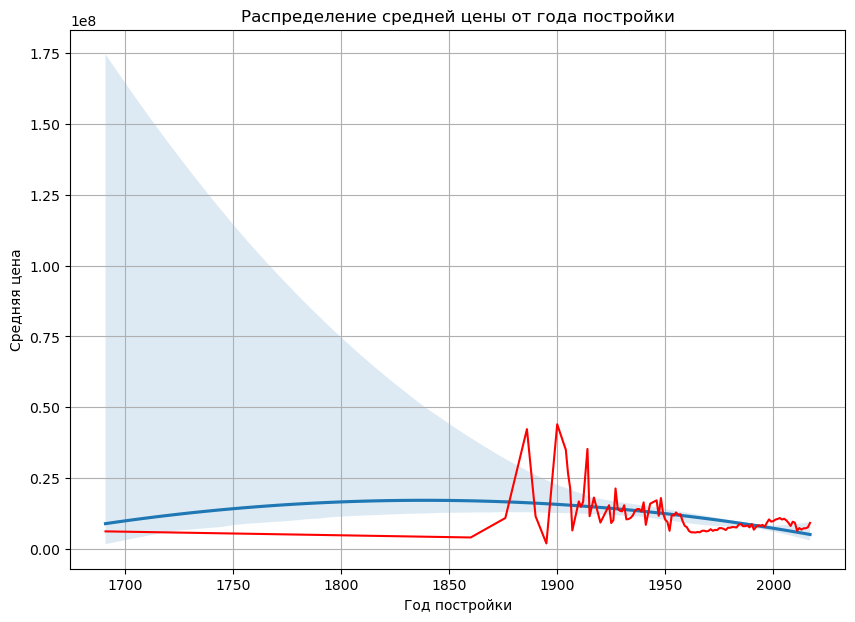

In [34]:
f, ax = plt.subplots(figsize=(10, 7))
data_by_price = train_df.groupby("build_year")[["build_year", "price_doc"]].mean()
sns.regplot(x="build_year", y="price_doc", data=data_by_price, scatter=False, order=2, truncate=True)
plt.plot(data_by_price['build_year'], data_by_price['price_doc'], color='r')
ax.set(title='Распределение средней цены от года постройки', xlabel='Год постройки', ylabel='Средняя цена')

### Временной промежуток
Рассмотрим как меняется цена продажи в зависимости от временного промежутка? 
Здесь происходит группировка по дням и вычисляется медианная за каждый день. Также рассматривается график изменения цены с течением времени.

In [35]:
price_timestamp = train_df.groupby("timestamp")["price_doc"].median().reset_index()
price_timestamp["timestamp"] = price_timestamp["timestamp"].apply(lambda x: x.value) 

[Text(0.5, 1.0, 'Медианная дневная цена с течением времени'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Цена')]

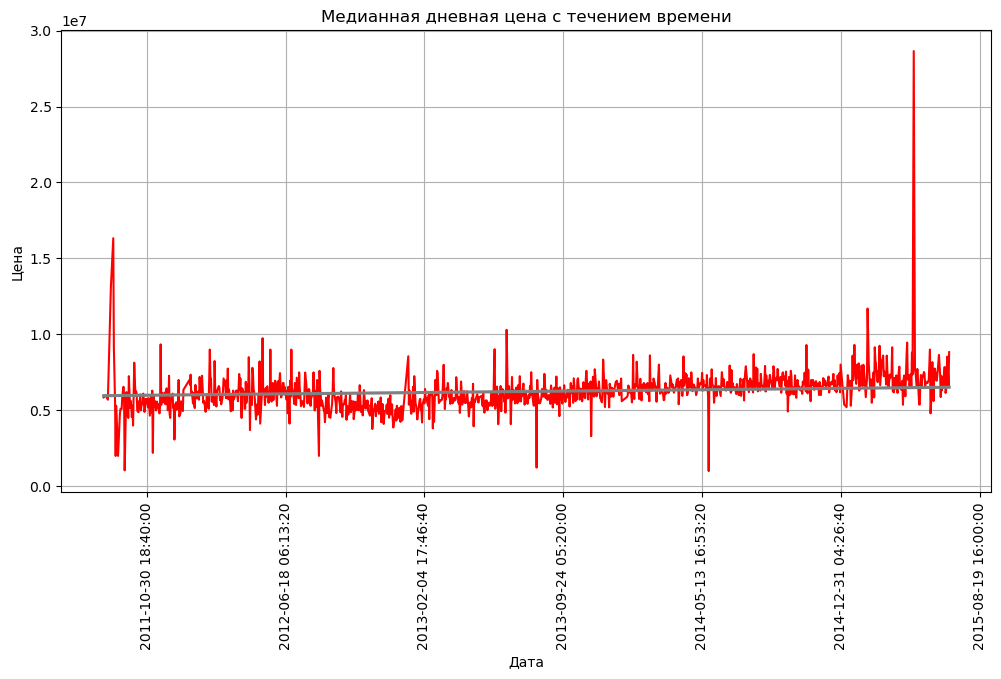

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='timestamp', y="price_doc", data=price_timestamp, color='red', ax=ax)
sns.regplot(x='timestamp', y="price_doc", data=price_timestamp, scatter=False, color='grey', ci=None, ax=ax)
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(FixedLocator(ticks_loc))  

date_labels = [pd.Timestamp(tick) for tick in ticks_loc]
ax.xaxis.set_major_formatter(FixedFormatter(date_labels))
for label in ax.get_xticklabels():
    label.set_rotation(90)
ax.set(title="Медианная дневная цена с течением времени", xlabel="Дата", ylabel="Цена")

Также для сравнения построим график объема продаж за все время

[Text(0.5, 1.0, 'Объем продаж за все время'),
 Text(0, 0.5, 'Количество продаж'),
 Text(0.5, 0, 'Дата')]

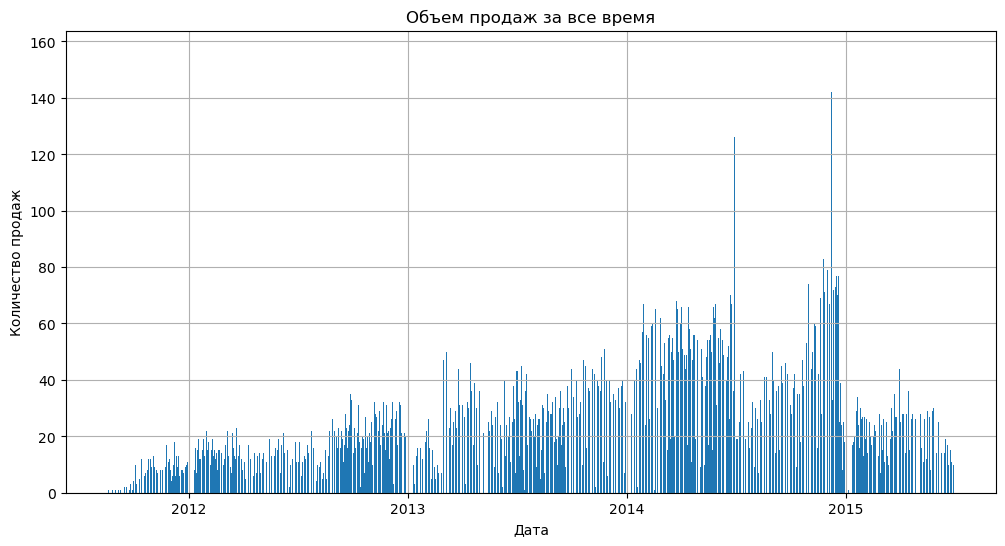

In [37]:
years = mdates.YearLocator()  
yearsFmt = mdates.DateFormatter('%Y')
ts_vc = train_df['timestamp'].value_counts()
f, ax = plt.subplots(figsize=(12, 6))
plt.bar(x=ts_vc.index, height=ts_vc)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Объем продаж за все время', ylabel='Количество продаж', xlabel='Дата')

Посмотрим имеется ли сезонность в ценах на жилье в течении года. Для этого рассмотрим распределение медианных цен по месяцам.

[Text(0.5, 0, 'Месяц'),
 Text(0, 0.5, 'Медианная цена'),
 Text(0.5, 1.0, 'График медианных цен от месяца')]

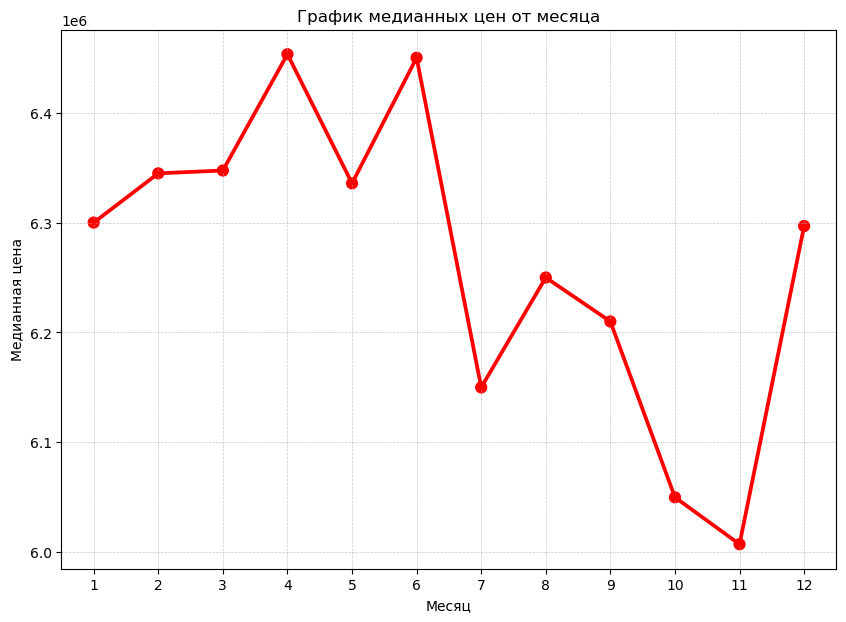

In [38]:
f, ax = plt.subplots(figsize= (10, 7))
season_price = (
    train_df.groupby(train_df["timestamp"].dt.month)
    .agg(median_price_doc=('price_doc', 'median'))
    .reset_index()
).rename(columns={"timestamp": "month"})
sns.pointplot(data=season_price, x="month", y="median_price_doc", color='r')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
ax.set(xlabel="Месяц", ylabel="Медианная цена", title="График медианных цен от месяца")

Как можно заметить из данного графика, что в первой половине года цена на жилье несколько ниже, чем во второй половине года.

### Состояние дома

Рассмотрим как влияет состояние дома на его цену

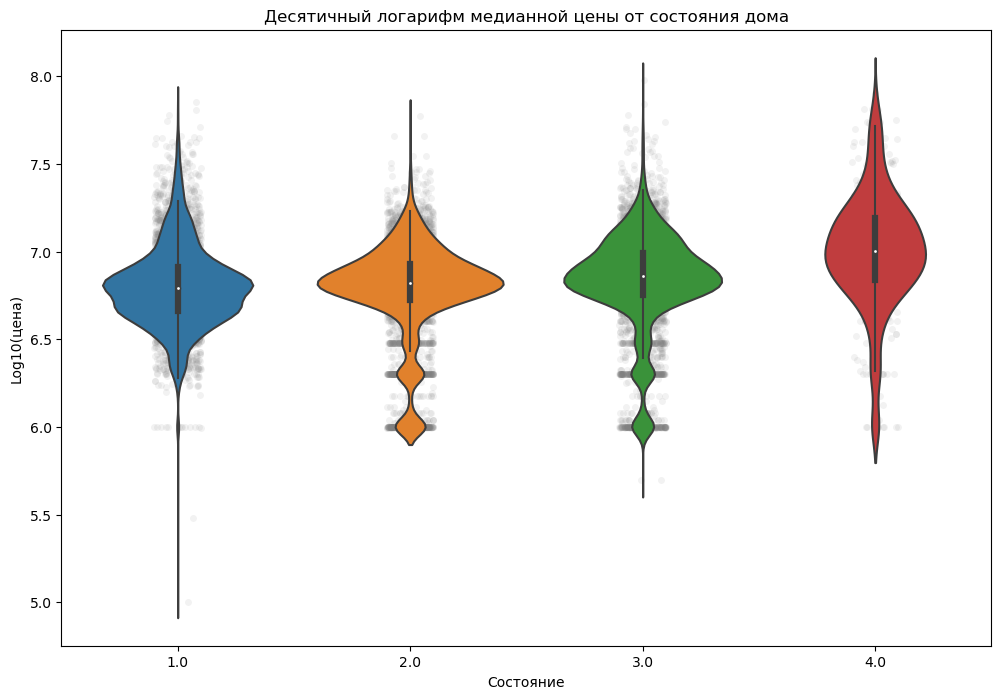

In [39]:
f, ax = plt.subplots(figsize=(12, 8))
home_state = train_df.dropna(subset=['state'])
sns.stripplot(
    x='state', 
    y=home_state['price_doc'].apply(np.log10), 
    data=home_state, 
    color='grey', 
    alpha=0.1,
    zorder=1,
    jitter=True
)
sns.violinplot(
    x='state', 
    y=home_state['price_doc'].apply(np.log10), 
    data=home_state, 
    inner="box",
    alpha=0.7,
    zorder=2,
)
ax.set(title="Десятичный логарифм медианной цены от состояния дома",
       xlabel="Состояние",
       ylabel="Log10(цена)")
ax.grid(False)

По графику трудно сказать, но, похоже, что в штате 4 в среднем самая высокая цена продажи. Однако значительно меньшее количество домов подпадает под эту категорию.

In [40]:
home_state.groupby("state").agg(median_price=("price_doc", "median")).reset_index()

state  median_price
0    1.0     6174925.0
1    2.0     6650000.0
2    3.0     7250000.0
3    4.0    10060000.0

При состоянии дома 4 самая высокая медианная цена на сегодняшний день, за ним следует состояние 3. Состояния 1 и 2 близки.

### Материал дома

Рассмотрим сколько имеется материалов домов и как соотносятся средняя цена на эти шесть материалов.

In [41]:
train_df['material'].value_counts().sort_index()

1.0    13408
2.0     2959
3.0        1
4.0     1284
5.0     1556
6.0      763
Name: material, dtype: int64

Как можно заметить наиболее распространенным является материал 1, а домов из материала 3 всего 1. Рассмотрим как он влияет на цену.

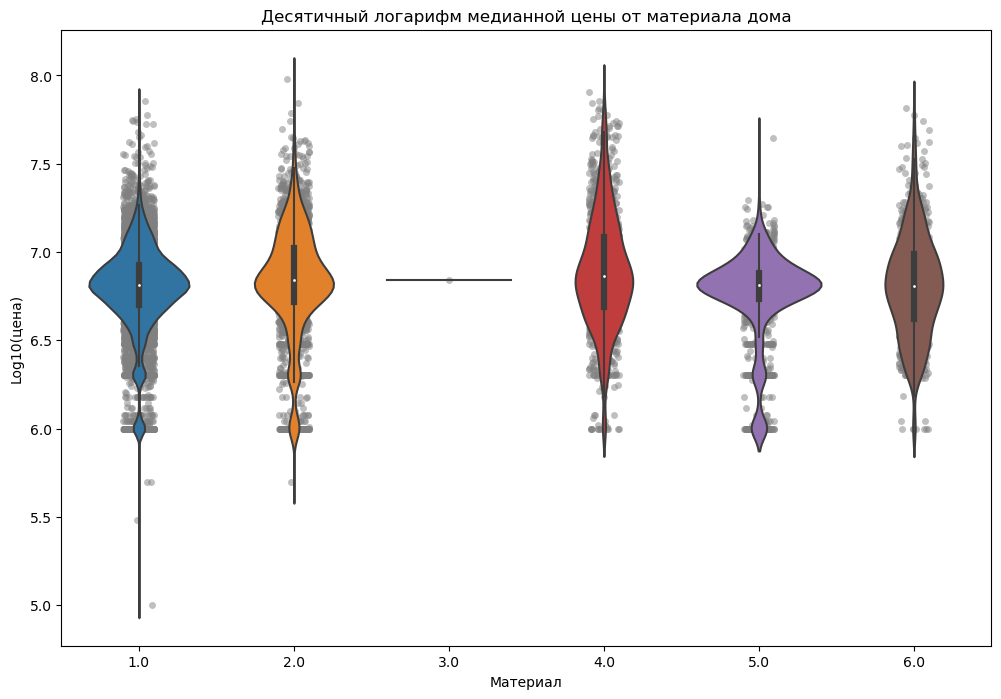

In [42]:
f, ax = plt.subplots(figsize=(12, 8))
materials = train_df.dropna(subset=["material"])
sns.stripplot(
    x='material', 
    y=materials['price_doc'].apply(np.log10), 
    data=materials, 
    color='grey', 
    alpha=0.5,
    zorder=1,
    jitter=True
)
sns.violinplot(
    x='material', 
    y=materials['price_doc'].apply(np.log10), 
    data=materials, 
    inner="box",
    alpha=0.7,
    zorder=2,
)
ax.set(title="Десятичный логарифм медианной цены от материала дома",
       xlabel="Материал",
       ylabel="Log10(цена)")
ax.grid(False)

Использование скрипчатой диаграммы дает хорошую визуализацию, но при этом посмотрим на табличные данные

In [43]:
home_state.groupby("material").agg(median_price=("price_doc", "median")).reset_index()

material  median_price
0       1.0     6700000.0
1       2.0     7000000.0
2       4.0     7641435.0
3       5.0     6500000.0
4       6.0     6700000.0

Как можно заметить, все цены примерно одинаковые, но чуть большей ценой обладает 4й материал

### Этаж в доме
Рассмотрим как этаж в доме соотносится с ценой.

In [44]:
train_df.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000',
       'price_doc', 'price_doc_log'],
      dtype='object', length=293)

[Text(0.5, 1.0, 'Десятичный логарифм цены от этажа дома'),
 Text(0.5, 0, 'Этаж'),
 Text(0, 0.5, 'Log10(цена)')]

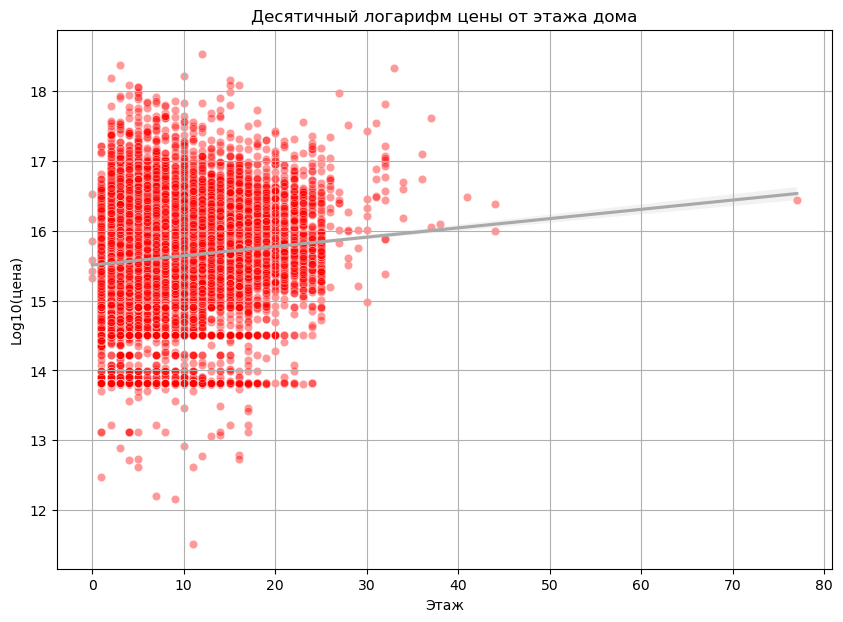

In [45]:
f, ax = plt.subplots(figsize=(10, 7))
train_df
sns.scatterplot(data=train_df, x="floor", y="price_doc_log", color='red', alpha=0.4)
sns.regplot(x="floor", y="price_doc_log", data=train_df, color='darkgrey', scatter=False, truncate=True)
ax.set(title="Десятичный логарифм цены от этажа дома",
       xlabel="Этаж",
       ylabel="Log10(цена)")

Как видно, что квартира на 80 этаже является явным выбросом. Отбросим ее.

In [46]:
train_df = train_df.drop(train_df[train_df['floor'] > 50].index)

[Text(0.5, 1.0, 'Десятичный логарифм цены от этажа дома'),
 Text(0.5, 0, 'Этаж'),
 Text(0, 0.5, 'Log10(цена)')]

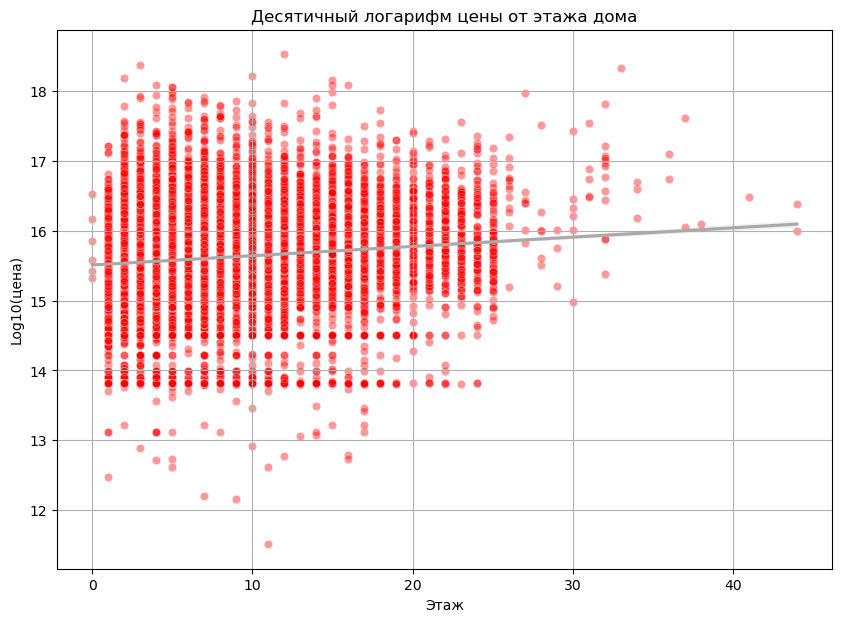

In [47]:
f, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=train_df, x="floor", y="price_doc_log", color='red', alpha=0.4)
sns.regplot(x="floor", y="price_doc_log", data=train_df, color='darkgrey', scatter=False, truncate=True)
ax.set(title="Десятичный логарифм цены от этажа дома",
       xlabel="Этаж",
       ylabel="Log10(цена)")

Цена, растет вместе с ростом этажа, хотя не достаточно сильно. Рассмотрим коррелирует ли высота здания с ценой. Высоту здания будем рассматривать по верхнему этажу здания (max_floor).

[Text(0.5, 1.0, 'Десятичный логарифм цены от верхнего этажа дома'),
 Text(0.5, 0, 'Верхний этаж'),
 Text(0, 0.5, 'Log10(цена)')]

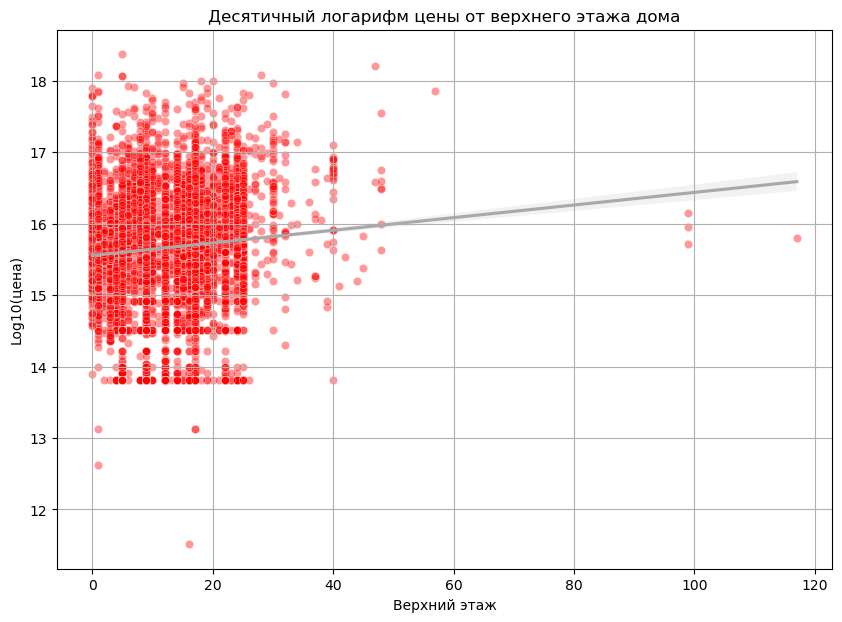

In [48]:
f, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=train_df, x="max_floor", y="price_doc_log", color='red', alpha=0.4)
sns.regplot(x="max_floor", y="price_doc_log", data=train_df, color='darkgrey', scatter=False, truncate=True)
ax.set(title="Десятичный логарифм цены от верхнего этажа дома",
       xlabel="Верхний этаж",
       ylabel="Log10(цена)")

Также имеются вполне явные выбросы со зданиями в более чем 80 этажей

In [49]:
train_df = train_df.drop(train_df[train_df['max_floor'] > 80].index)

[Text(0.5, 1.0, 'Десятичный логарифм цены от верхнего этажа дома'),
 Text(0.5, 0, 'Верхний этаж'),
 Text(0, 0.5, 'Log10(цена)')]

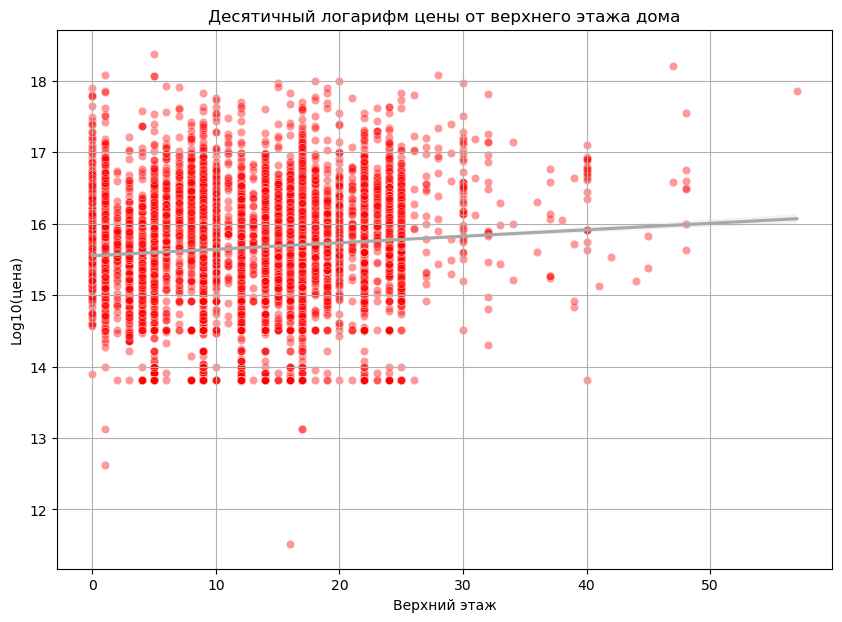

In [50]:
f, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=train_df, x="max_floor", y="price_doc_log", color='red', alpha=0.4)
sns.regplot(x="max_floor", y="price_doc_log", data=train_df, color='darkgrey', scatter=False, truncate=True)
ax.set(title="Десятичный логарифм цены от верхнего этажа дома",
       xlabel="Верхний этаж",
       ylabel="Log10(цена)")

Имеется небольшая положительная корреляция между ценой и высотой здания. Однако этот эффект, вероятно, усугубляется тем фактом, что в центре города есть как более дорогая недвижимость, так и более высокие здания. Таким образом, высота здания сама по себе, скорее всего, не является тем, что определяет цену.

Проверим качество данным и рассмотрим превышает ли значение floor значение max_floor для каких-либо наблюдений.

[Text(0.5, 0, 'floor'), Text(0, 0.5, 'max_floor')]

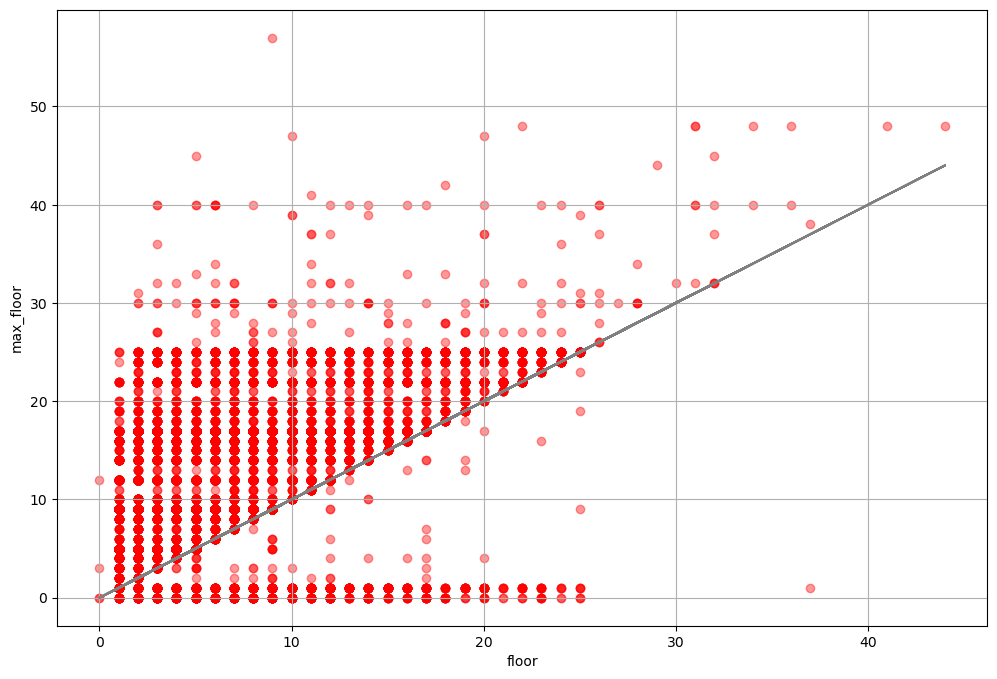

In [51]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
ax.plot(train_df['floor'], train_df['floor'], color='grey')
ax.set(xlabel='floor',
       ylabel='max_floor'
      )

Наблюдения под серой линией имеют этаж, превышающий количеств этажей в здании. Это нехорошо. Рассмотрим сколько таких случаев.

In [52]:
false_max_floor = train_df.loc[train_df['max_floor'] < train_df['floor'], ['id', 'floor','max_floor']]
false_max_floor

id  floor  max_floor
8216    8219   13.0        0.0
8268    8271    3.0        1.0
8499    8502    2.0        0.0
8531    8534    7.0        0.0
8912    8915    5.0        0.0
...      ...    ...        ...
30398  30401    5.0        1.0
30400  30403    3.0        0.0
30426  30429    1.0        0.0
30439  30442   12.0        0.0
30450  30453    5.0        0.0

[1257 rows x 3 columns]

Как можно заметить таких данных достаточно много 1257 строк. Также посмотрим какие чаще значения используются в max_floor. 

In [53]:
false_max_floor["max_floor"].value_counts()

1.0     730
0.0     467
3.0      13
2.0      10
4.0       8
5.0       5
6.0       5
9.0       3
14.0      3
10.0      2
7.0       2
13.0      2
11.0      1
17.0      1
23.0      1
12.0      1
16.0      1
19.0      1
18.0      1
Name: max_floor, dtype: int64

Больше всего значений 0 и 1, что не удивительно их чаще можно ввести случайно или использовать, как стандартные значения при отсутствии.

## Демографические и географические характеристики

Рассмотрим на сколько не относящиеся на прямую к дому параметры коррелируют с ценой.

In [54]:
other_features = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all',
                  'young_female', 'work_all', 'work_male', 'work_female', 'price_doc']
corr_matrix_other = train_df[other_features].corr()

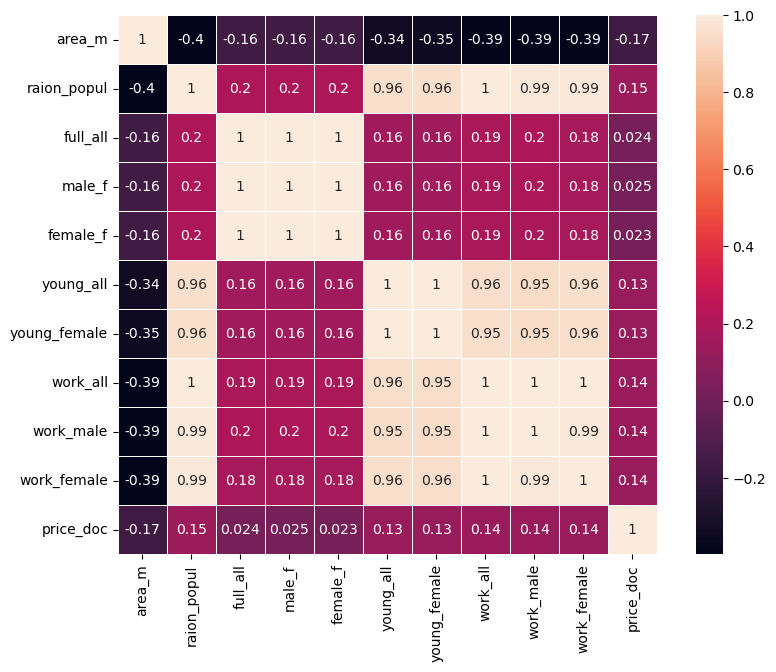

In [55]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation="vertical")
sns.heatmap(corr_matrix_other, square=True, linewidths=0.5, annot=True)
ax.grid(False)

Цена коррелирует с большинством из них, но корреляция довольно слабая.

### Плотность населения
Рассмотрим параметр sub_area, отвечающий за то в каком районе расположен дом.

In [56]:
train_df["sub_area"].value_counts()

Poselenie Sosenskoe               1700
Nekrasovka                        1549
Poselenie Vnukovskoe              1150
Poselenie Moskovskij               851
Poselenie Voskresenskoe            689
                                  ... 
Molzhaninovskoe                      3
Poselenie Shhapovskoe                2
Poselenie Kievskij                   2
Poselenie Klenovskoe                 1
Poselenie Mihajlovo-Jarcevskoe       1
Name: sub_area, Length: 146, dtype: int64

Есть несколько районов, плотность населения в которых, по-видимому, близка к нулю, что кажется странным.

Рассчитаю плотность населения и проверю, коррелирует ли она с ценой. Параметр area_m, по-видимому, представляет собой площадь (в квадратных метрах) района. Разделим area_m (в квадратных метрах) на 1000000, чтобы получить площадь подзоны в квадратных километрах. Затем разделим raion_popul на area_km, чтобы получить плотность населения для района.

[Text(0.5, 1.0, 'Медианная цена дома от плотности населения'),
 Text(0.5, 0, 'Плотность населения, чел/км^2'),
 Text(0, 0.5, 'Медианная цена')]

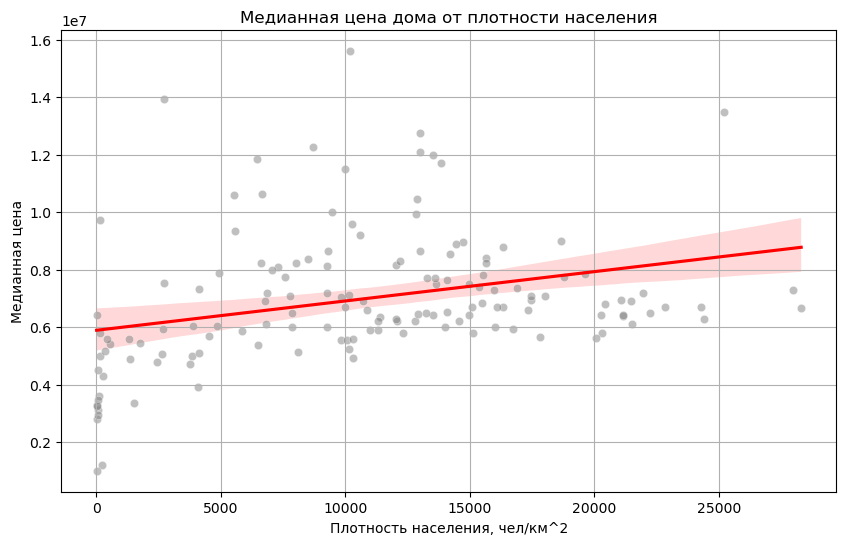

In [57]:
train_df["area_km"] = train_df["area_m"] / 1000000
train_df["density"] = train_df["raion_popul"] / train_df["area_km"]
demografic_df = train_df.groupby("sub_area")[["density", "price_doc"]].agg({"density": "median", "price_doc": "median"}).reset_index()
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="density", y="price_doc", data=demografic_df, scatter=False, truncate=True, color="r")
sns.scatterplot(x="density", y="price_doc", data=demografic_df, color='gray', alpha=0.5 )
ax.set(title='Медианная цена дома от плотности населения',
       xlabel="Плотность населения, чел/км^2",
       ylabel="Медианная цена")

Цена на жилье, похоже, действительно растет с увеличением плотности населения.

### Административный район
Получим представление о том, сколько сделок купли-продажи совершается в каждом районе.

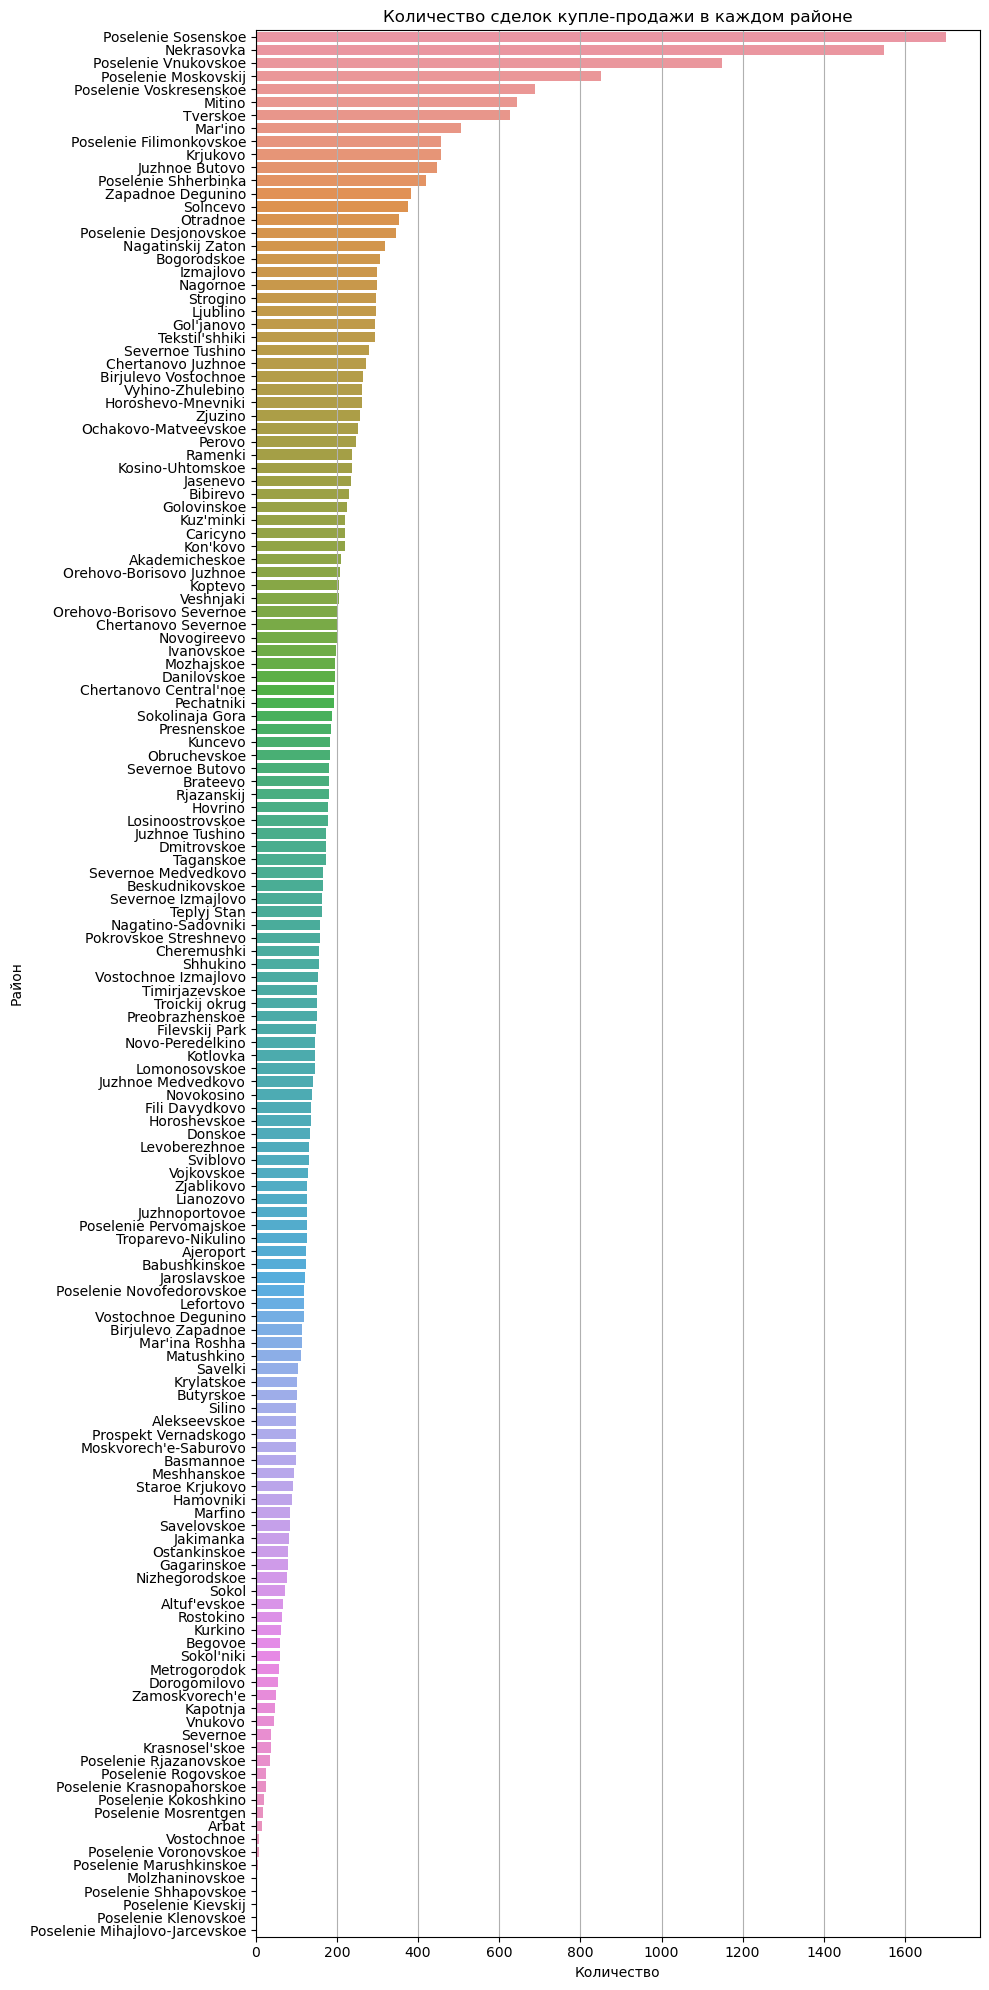

In [58]:
f, ax = plt.subplots(figsize=(10, 20))
sub_area_df = train_df['sub_area'].value_counts().reset_index().rename(columns={"index": "sub_area", "sub_area": "value"})
sns.barplot(data=sub_area_df, x="value", y="sub_area", orient="h")
ax.set(title='Количество сделок купле-продажи в каждом районе',
       xlabel='Количество',
       ylabel='Район')
f.tight_layout()

Как можнно заметить в Сосенское, Некрасовка, Внуковское было зафиксировано наибольшее количество сделок купле-продаже с довольно большим отрывом.

### Доля трудоспособного населения
Рассмотрим имеется ли взаимосвязь между долей населения трудоспособного возраста и ценой.

In [59]:
train_df["work_share"] = train_df["work_all"] / train_df["raion_popul"] * 100
work_share_df = train_df.groupby("sub_area").agg({"work_share": "median", "price_doc": "median"})

[Text(0.5, 1.0, 'Медианная цена от долей трудоспособного населения')]

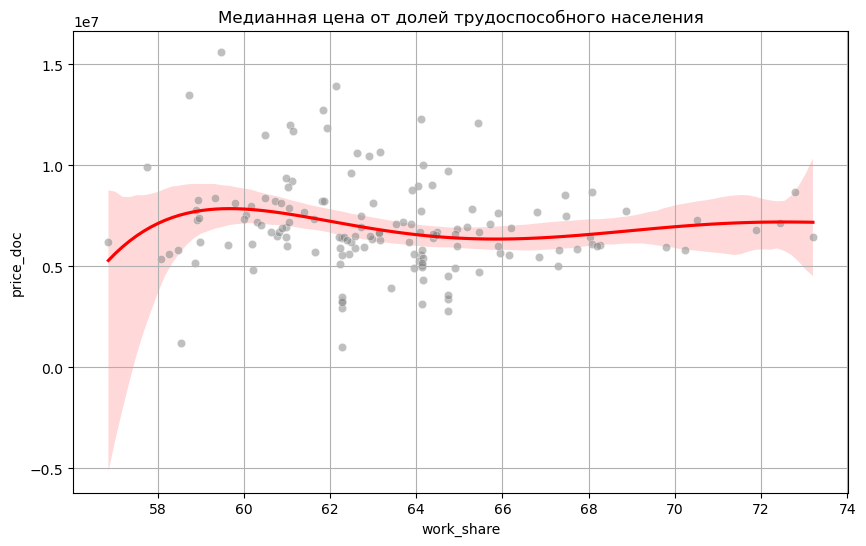

In [60]:
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="work_share", y="price_doc", data=work_share_df, order=5, color='r', scatter=False)
sns.scatterplot(x="work_share", y="price_doc", data=work_share_df, alpha=0.5, color='gray')
ax.set(title='Медианная цена от долей трудоспособного населения')

По-видимому, не существует взаимосвязи между ценой жилья и долей населения трудоспособного возраста в округе.

## Важность параметров
В данной части запускается модель градиентного бустинга, чтобы можно было использовать значения важности переменных. Чтобы избежать необходимости вменять недостающие данные прямо сейчас, я собираюсь подмножество dtrain включить только те наблюдения, которые имеют значения для каждой переменной.

In [61]:
X_train = train_df.copy()

y_train = X_train["price_doc"]
X_train = X_train.drop(labels=['timestamp', 'id', 'price_doc', 'price_doc_log'], axis=1)
categorical_features = []
for i, col_name in enumerate(X_train.columns):
    if X_train[col_name].dtype == "object":
        categorical_features.append(i)

In [62]:
catbr = cb.CatBoostRegressor(iterations=100, random_state=42)
catbr = catbr.fit(X_train, y_train, cat_features=categorical_features)
importances = catbr.feature_importances_
variables = pd.DataFrame(zip(X_train.columns, importances), columns=("variable", "value")).sort_values(by=["value"], ascending=False)
print(variables.head(20))

Learning rate set to 0.454433
0:	learn: 3852906.6949924	total: 234ms	remaining: 23.2s
1:	learn: 3393592.1717992	total: 374ms	remaining: 18.3s
2:	learn: 3115740.8615004	total: 490ms	remaining: 15.8s
3:	learn: 2966512.3178551	total: 610ms	remaining: 14.6s
4:	learn: 2869450.1147317	total: 699ms	remaining: 13.3s
5:	learn: 2806113.3536534	total: 793ms	remaining: 12.4s
6:	learn: 2755791.5586142	total: 886ms	remaining: 11.8s
7:	learn: 2719399.2604861	total: 981ms	remaining: 11.3s
8:	learn: 2693493.9374800	total: 1.07s	remaining: 10.9s
9:	learn: 2660562.8860664	total: 1.18s	remaining: 10.6s
10:	learn: 2628269.3213653	total: 1.25s	remaining: 10.2s
11:	learn: 2603159.1150514	total: 1.32s	remaining: 9.71s
12:	learn: 2592894.6766108	total: 1.38s	remaining: 9.23s
13:	learn: 2590469.0792962	total: 1.44s	remaining: 8.83s
14:	learn: 2569415.8318177	total: 1.5s	remaining: 8.53s
15:	learn: 2544699.2184490	total: 1.56s	remaining: 8.18s
16:	learn: 2540159.9933636	total: 1.6s	remaining: 7.82s
17:	learn: 25

После обучения модели catboost особое значение придается общей площади, а вот следующию параметры кажутся не совсем логичными, такими как кафе и его цена.
Посмотрим, что выдаст обучение xgboost модели.

In [63]:
for f in X_train.columns:
    if X_train[f].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(X_train[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))

[13:17:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



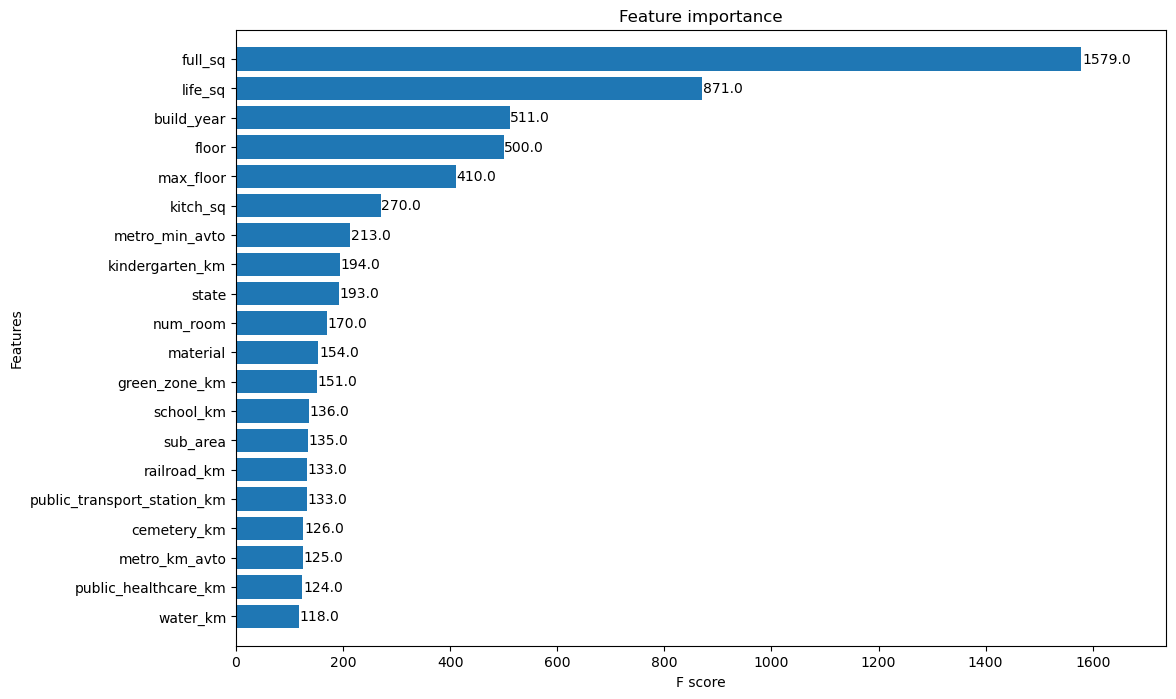

In [64]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)
ax.grid(False)
plt.show()

Данная модель кажется более понятной и скорее всего выделяет более значимые по смыслу параметры, такие как общая площадь, жилая площадь, год постройки и этаж, которые были рассмотренны ранее.